# SAM Summarization MVP

This notebook will demonstrate the process of using a pre-trained BART model for summarization of conversations from the SAMSum data set.

### Data Loading/Imports

In [1]:
import pandas as pd
import numpy as np
import evaluate
import torch

from tqdm import tqdm
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, TrainingArguments, Trainer

train_df = pd.read_csv('samsum_csv_data/train.csv')
validate_df = pd.read_csv('samsum_csv_data/validation.csv')

In [2]:
poc_train_df = train_df.head(500)
poc_validate_df = validate_df.head(20)

# Convert pandas DataFrames to 🤗 HF Dataset objects (ref based)
hf_train_dataset = Dataset.from_pandas(poc_train_df)
hf_validate_dataset = Dataset.from_pandas(poc_validate_df)

MODEL_NAME = "facebook/bart-base"

print(f"\nLoading tokenizer for model: {MODEL_NAME}...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer vocabulary size: {len(tokenizer)}")


Loading tokenizer for model: facebook/bart-base...
Tokenizer vocabulary size: 50265


### Pre-processing/Tokenization

Code for data pre-processing. We'll set a relatively long max input size and create a warning if conversations are truncated.

In [3]:
# In token counts (effectively word)
MAX_INPUT_LENGTH = 1024 # Some dialogs will likely exceed this
MAX_TARGET_LENGTH = 128 # If our summary is trying to go longer than this it's wrong

def preprocess_function(examples):
    tokenized_inputs = tokenizer(
        examples["dialogue"],
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding="max_length",
        return_overflowing_tokens=True,
        return_length=True
    )

    tokenized_labels = tokenizer(
        text_target=examples["summary"],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding="max_length"
    )

    for i, length in enumerate(tokenized_inputs["length"]):
        if length == MAX_INPUT_LENGTH and "overflowing_tokens" in tokenized_inputs:
            overflow = tokenized_inputs["overflowing_tokens"][i] if i < len(tokenized_inputs["overflowing_tokens"]) else []
            overflow_text = tokenizer.decode(overflow, skip_special_tokens=True)
            print(f"⚠️ Truncated example {i}: {overflow_text[:100]}...")

    tokenized_inputs["labels"] = tokenized_labels["input_ids"]
    return tokenized_inputs


print(f"\nPreprocessing training/validation data (tokenizing and aligning lengths)...")
tokenized_hf_train_dataset = hf_train_dataset.map(
    preprocess_function,
    batched=True, # Process examples in batches for speed
    remove_columns=['id', 'dialogue', 'summary'] # Remove original text columns
)

tokenized_hf_validate_dataset = hf_validate_dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=['id', 'dialogue', 'summary']
)


Preprocessing training/validation data (tokenizing and aligning lengths)...


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/20 [00:00<?, ? examples/s]

### Training Parameters

We are optimizing these training parameters to be GPU-memory-friendly at the cost of performance hits in other areas. `fp16=True, gradient_checkpointing=True` were tried elsewhere and did not allow scaling to 1000 samples.

In [ ]:
tokenized_hf_train_dataset.set_format("torch")
tokenized_hf_validate_dataset.set_format("torch")

print(f"\nLoading BART model for sequence-to-sequence: {MODEL_NAME}...")
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_NAME)
print("Model loaded successfully.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

output_dir = "./bart_samsum_poc_results"
print(f"\nSetting up Training Arguments. Output directory: {output_dir}")
# Includes some default values like num_train_epochs for future clarity
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=3,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=2,
    warmup_steps=10,
    weight_decay=0.01,
    logging_steps=5,
    eval_strategy="steps",
    eval_steps=10,
    save_steps=10,
    report_to="none",
    gradient_accumulation_steps=2, # Memory issues
    load_best_model_at_end=True,
    metric_for_best_model="rouge1", # Look for higher ROUGE-1 scores 
    greater_is_better=True
)

print("\nTraining Arguments configured.")


Loading BART model for sequence-to-sequence: facebook/bart-base...
Model loaded successfully.
Using device: cuda

Setting up Training Arguments. Output directory: ./bart_samsum_poc_results

Training Arguments configured.


### Training Metrics and Initialization

As instructed, we'll use ROUGE scores - a measure of word overlap between our target "reference" summary and our model's generated summary.

In [5]:
print("\nLoading ROUGE metric...")
rouge_metric = evaluate.load("rouge")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    predictions = predictions[0]
    predictions = np.argmax(predictions, axis=-1)

    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Post-process for ROUGE: remove extra whitespace and newlines
    decoded_preds = ["\n".join(pred.strip().split()) for pred in decoded_preds]
    decoded_labels = ["\n".join(label.strip().split()) for label in decoded_labels]

    result = rouge_metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    result = {k: round(v * 100, 4) for k, v in result.items()}
    return result

print("Metric computation function defined.")

print("\nInitializing the Trainer...")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_hf_train_dataset,
    eval_dataset=tokenized_hf_validate_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

print("Trainer initialized successfully. Ready for training.")


Loading ROUGE metric...
Metric computation function defined.

Initializing the Trainer...
Trainer initialized successfully. Ready for training.


/tmp/ipykernel_7257/288411429.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### Training

Choose your own training montage music.

In [ ]:
print("\nStarting model training...")
train_result = trainer.train()
print("Training complete.")

trainer.save_model()

metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

print(f"\nModel and tokenizer saved to: {training_args.output_dir}")
print("Training metrics logged and saved.")

print("\nRunning final evaluation on the validation set...")
eval_metrics = trainer.evaluate(eval_dataset=tokenized_hf_validate_dataset)
trainer.log_metrics("eval", eval_metrics)
trainer.save_metrics("eval", eval_metrics)
print("Final evaluation complete.")
print(eval_metrics)


Starting model training...


Step,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
10,11.204600,10.251661,42.117600,21.862000,39.190100,42.160200
20,8.172100,6.499501,28.307100,15.460400,27.330000,28.296700
30,5.337400,3.831983,53.516400,27.167200,51.186200,53.611200
40,3.582900,2.712469,55.076200,27.645000,51.537600,55.054500
50,2.632200,1.768104,56.127500,29.986300,54.374600,56.113300
60,1.783200,1.063573,59.022900,36.889200,57.750200,59.105900
70,1.191700,0.648764,56.315700,32.849800,54.723100,56.360100
80,0.965300,0.462819,58.052000,35.492800,56.658800,58.130400
90,0.830200,0.383688,58.753100,33.859600,57.085500,58.871200
100,0.535100,0.396347,53.088300,31.047400,51.459700,53.102200


/home/paul/miniconda3/envs/pytorch_env/lib/python3.10/site-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


Training complete.
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   851791GF
  train_loss               =     0.8301
  train_runtime            = 0:12:19.14
  train_samples_per_second =      2.029
  train_steps_per_second   =      1.015

Model and tokenizer saved to: ./bart_samsum_poc_results
Training metrics logged and saved.

Running final evaluation on the validation set...


***** eval metrics *****
  epoch                   =        3.0
  eval_loss               =     0.3291
  eval_rouge1             =    63.8728
  eval_rouge2             =    38.3221
  eval_rougeL             =    61.6562
  eval_rougeLsum          =    64.0096
  eval_runtime            = 0:00:01.83
  eval_samples_per_second =     10.899
  eval_steps_per_second   =      5.449
Final evaluation complete.
{'eval_loss': 0.32907551527023315, 'eval_rouge1': 63.8728, 'eval_rouge2': 38.3221, 'eval_rougeL': 61.6562, 'eval_rougeLsum': 64.0096, 'eval_runtime': 1.8351, 'eval_samples_per_second': 10.899, 'eval_steps_per_second': 5.449, 'epoch': 3.0}


#### Model Evaluation

The model maintained its performance on conversations it hasn't already seen, indicating that overfitting us not a major concern presently. Let's take a look at some examples next.

In [ ]:
output_dir = "./bart_samsum_poc_results"

# Load the fine-tuned model and tokenizer
print(f"\nLoading 'fine-tuned' model and tokenizer from {output_dir}...")
device = "cpu"
print(f"Using device: {device}")

loaded_tokenizer = AutoTokenizer.from_pretrained(output_dir)
loaded_model = AutoModelForSeq2SeqLM.from_pretrained(output_dir).to(device)

print("Model and tokenizer loaded successfully for inference.")

num_examples_to_show = 3

example_data = validate_df.sample(n=num_examples_to_show,
                                   random_state=42).to_dict('records')


print("\n--- Model Inference Examples ---")
for i, example in enumerate(example_data):
    dialogue = example['dialogue']
    reference_summary = example['summary']

    # Tokenize the input dialogue
    inputs = loaded_tokenizer(
        dialogue,
        return_tensors="pt", # Pytorch
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    ).to(device) # Move inputs to the correct device (CPU/GPU)

    # Generate summary
    # Using parameters that typically work well for summarization
    summary_ids = loaded_model.generate(
        inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        num_beams=4,        # Use beam search for better quality summaries
        max_length=MAX_TARGET_LENGTH, # Max length of generated summary
        min_length=30,      # Minimum length to encourage more detailed summaries
        early_stopping=True, # Stop generation when all beam hypotheses are complete
        length_penalty=2.0  # Encourage longer summaries (common for abstractive summarization)
    )

    # Decode the generated summary IDs back to text
    generated_summary = loaded_tokenizer.decode(summary_ids[0], skip_special_tokens=True)

    print(f"\n--- Example {i+1} ---")
    print(f"Original Dialogue:\n{dialogue}")
    print(f"\nReference Summary:\n{reference_summary}")
    print(f"\nGenerated Summary:\n{generated_summary}")
    print("-" * 30)


Loading fine-tuned model and tokenizer from ./bart_samsum_poc_results...
Using device: cpu
Model and tokenizer loaded successfully for inference.

--- Model Inference Examples ---

--- Example 1 ---
Original Dialogue:
Edd: wow, did you hear that they're transferring us to a different department?
Rose: whaaaaat :o
Rose: no! where'd you hear that?
Edd: well, it's quite official
Edd: Anderson just told us
Rose: and do you know what it changes for us?
Edd: they won't change the professors
Edd: but i know the paperwork will get trickier
Rose: and i guess that is a move that is supposed to make everything easier
Edd: yeah, guess so
Edd: they have a funny way of understanding 'to make things easier'

Reference Summary:
Rose and Edd will be transferred to a new department. Their professors will not change but paperwork will become more difficult.

Generated Summary:
Edd and Rose are transferred to a different department. They will change the professors, but the paperwork will get trickier. Th

### Post-Model Evaluation

In [2]:
import os
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Base directory where Trainer saved outputs
base_dir = "./bart_samsum_poc_results"

# Find the latest or best checkpoint
checkpoint_dirs = [os.path.join(base_dir, d) for d in os.listdir(base_dir) if d.startswith("checkpoint-")]
best_checkpoint = max(checkpoint_dirs, key=os.path.getmtime) if checkpoint_dirs else base_dir

# Load model and tokenizer from the best checkpoint
print(f"Loading model from: {best_checkpoint}")
model = AutoModelForSeq2SeqLM.from_pretrained(best_checkpoint)
tokenizer = AutoTokenizer.from_pretrained(best_checkpoint)


Loading model from: ./bart_samsum_poc_results/checkpoint-750


In [5]:
from tqdm import tqdm
import numpy as np
import evaluate

rouge_metric = evaluate.load("rouge")

def compute_rouge_from_generation(model, tokenizer, df, input_column="dialogue", label_column="summary", batch_size=8, max_input_length=1024, max_output_length=128):
    preds, refs = [], []
    model.eval()

    for i in tqdm(range(0, len(df), batch_size)):
        batch = df.iloc[i:i+batch_size]
        inputs = tokenizer(
            batch[input_column].tolist(),
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_input_length
        ).to(model.device)

        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_length=max_output_length,
                num_beams=2,
                early_stopping=True
            )

        decoded_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        decoded_labels = tokenizer.batch_decode(
            tokenizer(
                batch[label_column].tolist(),
                truncation=True,
                padding=True,
                max_length=max_output_length
            )["input_ids"],
            skip_special_tokens=True
        )

        # Post-process for ROUGE
        preds.extend(["\n".join(p.strip().split()) for p in decoded_preds])
        refs.extend(["\n".join(r.strip().split()) for r in decoded_labels])

    # Compute ROUGE
    result = rouge_metric.compute(predictions=preds, references=refs, use_stemmer=True)
    return {k: round(v * 100, 4) for k, v in result.items()}


In [6]:
tramainder_df = train_df.iloc[500:1000].reset_index(drop=True)
rouge_scores = compute_rouge_from_generation(model, tokenizer, tramainder_df)
print(rouge_scores)


100%|██████████| 63/63 [04:26<00:00,  4.24s/it]


{'rouge1': np.float64(44.1087), 'rouge2': np.float64(19.7603), 'rougeL': np.float64(35.9553), 'rougeLsum': np.float64(44.0745)}


In [7]:
import random
random.seed(42)
sample_indices = random.sample(range(500), 5)


In [8]:
sample_indices

[327, 57, 12, 379, 140]

### Side by Side (by Side by Side)

I'm going to break the "we" voice here in order to explain my process. First, I randomly selected 5 samples dialogs. Without looking at the reference summaries, I generated my own human-written summary of the conversation. I then gave those same dialogs to Copilot and asked it to write its own summaries. This resulted in four summaries for each dialog - mine, Copilot's, the original reference, and BART's.

Next I asked Copilot to subjectively rate each of the four summaries. I felt that asking an LLM to do this was the best way of getting close to an objective assessment and made it clear I didn't want it to give "special treatment" to either my summaries or the target/reference. It seems to have followed that instruction. I was expecting Copilot to consistently rate its own summaries highest, which it did, and that makes sense.

For the rating scale, I asked for initial ratings on a 1-100 scale, with 100 constituting a "perfect" summary that captures all important information with brevity. Notably, any score below 50 indicates a "negative summary" - the summary misses key details or hallucinates in such a way that it creates additional confusion.

To extend this, I took the subjective rating, subtracted 50 in order to put it into symmetrical negative/positive territory, and divided by the character count, rewarding brevity (crucial for summaries).

In [ ]:
import random

# Reproducible sample
random.seed(42)
sample_indices = [327, 57, 12, 379, 140]
offset = 500  # since we're indexing from train_df[500:1000]
true_indices = [offset + i for i in sample_indices]

for i, idx in enumerate(true_indices):
    print(f"\n### 🗣️ Sample {i+1} (Index {idx}) ###\n")
    print(train_df.loc[idx, "dialogue"])



### 🗣️ Sample 1 (Index 827) ###

Ivy: What's the door code?
Dawn: 4537
Adrian: it's the apartment number followed by the key button followed by 4537
Ivy: I don think it's working. I'm calling the apartment
Dawn: Maybe you wait too long before pushing the key button  - it calls the apartment after 3 seconds
Ivy: ok
Ivy: ok it worked this time
Dawn: and inside it's the 3rd floor
Ivy: thanks ;)
Adrian: good luck

### 🗣️ Sample 2 (Index 557) ###

Elijah: What do you think about a new coach?
Owen: I don’t think he’ll change anything
Elijah: Why
Owen: Look, he has some new ideas, that’s true, but he doesn’t seem to control anything
Elijah: It’s all a bit messy, true. But it’s just the beginning, a few first games
Owen: Aaand let’s hope it’ll get better, if not, we’re absolutely screwed
Elijah: I believe in him, ha has such a wit, a lot of energy
Owen: But he is NOT a good professional, you’ll see
Elijah: Ehhh we can never afford someone really good…

### 🗣️ Sample 3 (Index 512) ###

Tony: H

In [ ]:
# Put summaries by me and copilot into a structure; we'll add bart+ref next
summaries = {
    1: {
        "paul": "Dawn and Adrian are helping Ivy get into a building - there is some confusion with the door code.",
        "copilot": "Ivy had trouble entering the apartment but eventually got in after some clarification on the entry code. Dawn and Adrian offered guidance and directions once inside.",
        "bart": None,
        "reference": None
    },
    2: {
        "paul": "Elijah and Owen are discussing a new coach. Owen is skeptical but Elijah is more optimistic.",
        "copilot": "Elijah and Owen debate the merits of a new coach—Elijah is optimistic about his energy, while Owen doubts his professionalism and impact.",
        "bart": None,
        "reference": None
    },
    3: {
        "paul": "Tony is asking for information about Jim's printing business. He needs 12 prints done quickly. Jim explains this is possible but will be a higher charge.",
        "copilot": "Tony inquires about urgent canvas prints, and Jim confirms they can fulfill the 12-print order by the weekend for an express fee of £65 each.",
        "bart": None,
        "reference": None
    },
    4: {
        "paul": "Helen is proposing a night at the pub this Saturday. Thomas can't make it, but Anette and Tanvi will attend - 7:30 is the proposed time.",
        "copilot": "Helen and friends try to coordinate pub plans for Saturday, with Anette also suggesting a bop at Darwin. Final meetup time and place are still open.",
        "bart": None,
        "reference": None
    },
    5: {
        "paul": "Enrique is not impressed by Alvin's latest brew and shares this with Travis.",
        "copilot": "Enrique warns Travis that Alvin’s food from the night before was terrible and left a lingering bad taste.",
        "bart": None,
        "reference": None
    }
}


In [ ]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

train_df = pd.read_csv("samsum_csv_data/train.csv")

# Reuse/hardcode random indices used earlier
sample_indices = [827, 557, 512, 879, 640]

model = AutoModelForSeq2SeqLM.from_pretrained("./bart_samsum_poc_results/checkpoint-750")  # replace with actual checkpoint path
tokenizer = AutoTokenizer.from_pretrained("./bart_samsum_poc_results/checkpoint-750")
model.eval().to("cuda" if torch.cuda.is_available() else "cpu")

# Generate summaries with BART and extract references
for i, idx in enumerate(sample_indices, start=1):
    dialogue = train_df.loc[idx, "dialogue"]
    reference = train_df.loc[idx, "summary"]
    
    # Reference
    summaries[i]["reference"] = reference

    # Generate BART summary
    inputs = tokenizer(
        dialogue,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    
    with torch.no_grad():
        output_ids = model.generate(
            **inputs,
            max_length=128,
            num_beams=2,
            early_stopping=True
        )
    bart_summary = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    summaries[i]["bart"] = bart_summary

# Print all four summaries together
for i in range(1, 6):
    print(f"\n=== Sample {i} ===")
    for label in ["paul", "copilot", "bart", "reference"]:
        print(f"{label.title()}: {summaries[i][label]}")



=== Sample 1 ===
Paul: Dawn and Adrian are helping Ivy get into a building - there is some confusion with the door code.
Copilot: Ivy had trouble entering the apartment but eventually got in after some clarification on the entry code. Dawn and Adrian offered guidance and directions once inside.
Bart: Adrian's apartment number is 4537.
Reference: The door code is the apartment number followed by the key button followed by 4537. The entry phone calls the apartment 3 seconds after pushing the apartment number. The apartment is on the 3rd floor.

=== Sample 2 ===
Paul: Elijah and Owen are discussing a new coach. Owen is skeptical but Elijah is more optimistic.
Copilot: Elijah and Owen debate the merits of a new coach—Elijah is optimistic about his energy, while Owen doubts his professionalism and impact.
Bart: Owen doesn't think a new coach will change anything.
Reference: New coach has come with new ideas but after first few games he is judged poorly by Owen and Elijah.

=== Sample 3 ===

In [ ]:
import evaluate

rouge = evaluate.load("rouge")
rouge_results = {}


for i in range(1, 6):
    ref = summaries[i]["reference"]
    rouge_results[i] = {}

    for label in ["paul", "copilot", "bart"]:
        pred = summaries[i][label]

        scores = rouge.compute(
            predictions=[pred],
            references=[ref],
            use_stemmer=True
        )

        # Round and store
        rouge_results[i][label] = {k: round(v * 100, 2) for k, v in scores.items()}


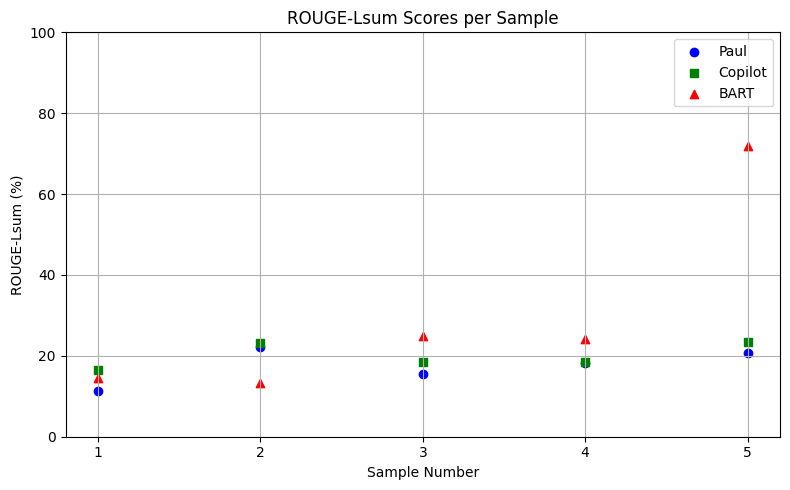

In [ ]:
rouge_lsum_scores = {"paul": [], "copilot": [], "bart": []}

for i in range(1, 6):
    reference = summaries[i]["reference"]
    for label in ["paul", "copilot", "bart"]:
        prediction = summaries[i][label]
        score = rouge.compute(
            predictions=[prediction],
            references=[reference],
            use_stemmer=True
        )["rougeLsum"]
        rouge_lsum_scores[label].append(round(score * 100, 2))

import matplotlib.pyplot as plt

x = list(range(1, 6))  # Sample indices

plt.figure(figsize=(8, 5))
plt.scatter(x, rouge_lsum_scores["paul"], label="Paul", color="blue", marker="o")
plt.scatter(x, rouge_lsum_scores["copilot"], label="Copilot", color="green", marker="s")
plt.scatter(x, rouge_lsum_scores["bart"], label="BART", color="red", marker="^")

plt.title("ROUGE-Lsum Scores per Sample")
plt.xlabel("Sample Number")
plt.ylabel("ROUGE-Lsum (%)")
plt.ylim(0, 100)
plt.xticks(x)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 🧮 Subjective Summary Ratings (Scale: 1–100)

(Written by Copilot, see above)

---

##### Sample 1
**Meta-summary:** This was a pragmatic interaction about gaining building access. Paul and Copilot each captured the gist well, though Copilot included slightly more detail. BART hallucinated a fact, and the reference was accurate but overly specific and verbose.
- **Paul**: 85
- **Copilot**: 90
- **BART**: 30
- **Reference**: 70

---

##### Sample 2
**Meta-summary:** This was a value judgment conversation—opinion-driven. Copilot’s wording precisely outlined the positions. Paul got the tone right, though less nuanced. BART oversimplified by only referencing Owen. Reference missed the optimism entirely.
- **Paul**: 80
- **Copilot**: 88
- **BART**: 55
- **Reference**: 50

---

##### Sample 3
**Meta-summary:** This interaction involved quantity, urgency, price shifts, and commitment. Copilot’s version was tightly scoped, accurate, and economical. Paul’s was good but missed the final price and deadline. BART was vague and skipped key details. Reference got everything but overexplained.
- **Paul**: 78
- **Copilot**: 92
- **BART**: 45
- **Reference**: 75

---

##### Sample 4
**Meta-summary:** This one had scattered logistics with shifting attendees and multiple event options. Paul nailed the time and invitees but missed the bop entirely. Copilot recognized the Darwin angle and ambiguity of plans. BART hallucinated and confused people/events. Reference got names right but felt more like shorthand.
- **Paul**: 75
- **Copilot**: 83
- **BART**: 40
- **Reference**: 68

---

##### Sample 5
**Meta-summary:** This was a dead-simple exchange—pure sentiment. Paul and Copilot both conveyed it well; Copilot captured tone more precisely. BART totally misread the interaction. Reference technically aligned, but phrasing was clumsy and unclear.
- **Paul**: 85
- **Copilot**: 88
- **BART**: 35
- **Reference**: 60


In [21]:
import pandas as pd

# Subjective raw scores from earlier
subjective_scores = {
    1: {"paul": 85, "copilot": 90, "bart": 30, "reference": 70},
    2: {"paul": 80, "copilot": 88, "bart": 55, "reference": 50},
    3: {"paul": 78, "copilot": 92, "bart": 45, "reference": 75},
    4: {"paul": 75, "copilot": 83, "bart": 40, "reference": 68},
    5: {"paul": 85, "copilot": 88, "bart": 35, "reference": 60}
}

# Assuming `summaries` dictionary is defined with all summaries already populated
rows = []
for sample_id in range(1, 6):
    for author in ["paul", "copilot", "bart", "reference"]:
        summary = summaries[sample_id][author]
        raw_score = subjective_scores[sample_id][author]
        char_count = len(summary)
        adjusted_score = round((raw_score - 50) / char_count, 4)
        rows.append({
            "Sample": sample_id,
            "Author": author.title(),
            "Raw Score": raw_score,
            "Char Count": char_count,
            "Length-Adjusted Score": adjusted_score
        })

df = pd.DataFrame(rows)
df


,Sample,Author,Raw Score,Char Count,Length-Adjusted Score
0,1,Paul,85,97,0.3608
1,1,Copilot,90,165,0.2424
2,1,Bart,30,34,-0.5882
3,1,Reference,70,199,0.1005
4,2,Paul,80,92,0.3261
5,2,Copilot,88,137,0.2774
6,2,Bart,55,52,0.0962
7,2,Reference,50,99,0.0000
8,3,Paul,78,153,0.1830
9,3,Copilot,92,141,0.2979


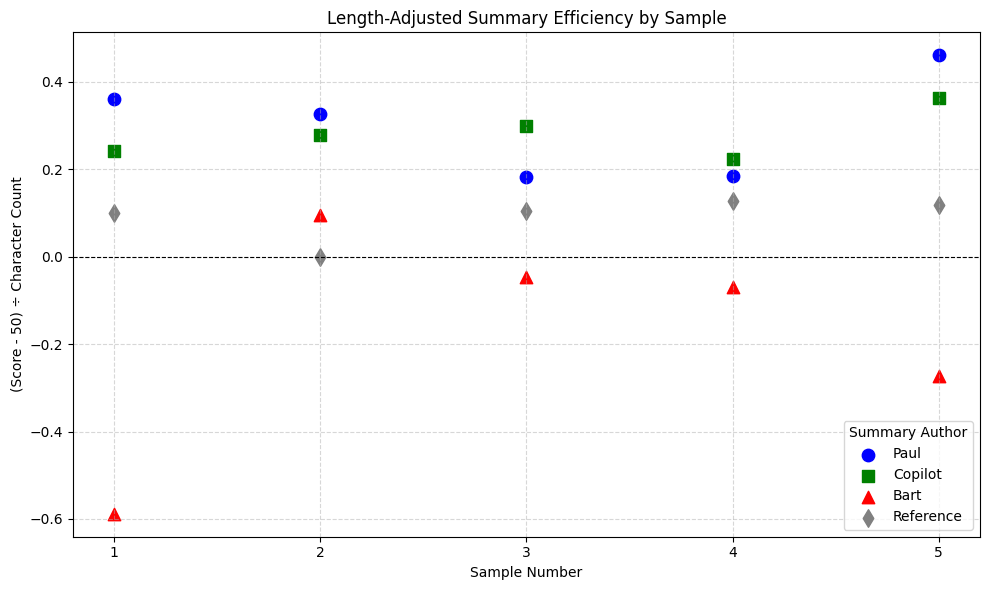

In [ ]:
plt.figure(figsize=(10, 6))

# Define authors and markers/colors
authors = ["Paul", "Copilot", "Bart", "Reference"]
colors = ["blue", "green", "red", "gray"]
markers = ["o", "s", "^", "d"]

for author, color, marker in zip(authors, colors, markers):
    scores = df[df["Author"] == author]["Length-Adjusted Score"]
    samples = df[df["Author"] == author]["Sample"]
    plt.scatter(samples, scores, label=author, color=color, marker=marker, s=80)
    
plt.title("Length-Adjusted Summary Efficiency by Sample")
plt.xlabel("Sample Number")
plt.ylabel("(Score - 50) ÷ Character Count")
plt.xticks(range(1, 6))
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(title="Summary Author")
plt.tight_layout()
plt.show()

- Tony: How much do you charge for canvas prints 30 x40cm?
- Jim: They're usually 60 pounds each.
- Jim: But this week they're on promotion for 45 each.
- Tony: Thanks. What's the lead time on the print?
- Jim: Usually 7 days but we're a bit busy atm so it might be a little more.
- Tony: How much more?
- Jim: Up to 2 weeks.
- Tony: I need them by this weekend.
- Jim: How many were you thinking of ordering?
- Tony: I need 12 of them.
- Jim: Same design or each one different?
- Tony: Same design.
- Jim: Let me check with our print shop and I'll let you know if we can get them done.
- Jim: Checked with the print shop and we can do them.
- Jim: But we'll have to charge a little bit extra.
- Jim: Cause it will be termed as express service.
- Tony: Thanks for the info.
- Tony: How much extra?
- Jim: 65 each.
- Tony: Thanks. I'll let you know if I decide to go with you.
- Jim: I'd need the info from you by EOD if you want us to do the prints by the weekend.
- Tony: OK.

### Four Summary Analysis

First, this highlights the "garbage in, garbage out" problem. Our BART model did perform substantially worse than the reference summary by **Copilot's subjective opinion** (except in one case). But from this small sample, the reference summaries do not look great.

It also shows that it's hard to define "best summary" in a vacuum. Copilot rated my summary of Sample 3, the printing discussion, fairly low (a 78) because I didn't include the final price/deadline. But is that information crucial to whoever's reading the summary?

There are several possible perspectives or target audiences for summaries. Here are a few:

- Type A: "I just want the gist so I can know whether to read the conversation" - this target audience does not need specifics such as price and deadlines.
- Type B: "I want all final details but don't care about the process" - this audience absolutely requires final details such as price and deadlines, but could be spared intermediate details - they don't need to know about the sale price of 45 pounds because that's not relevant to the final agreement.
- Type C: "I want it all" - looking for all of the details, just in a more organized fashion. Stops becoming a summary.

Examples:

- A: "Jim is providing information about his printing business to Tony."
- B: "Tony needs 12 canvas prints, all of the same design, by this weekend. Jim's print shop can accommodate this express service, but the cost will be £65 per print. Tony must provide the necessary information by end of day for weekend delivery."

### Top N

In [23]:
# Rewrite of earlier code which did not store the summaries
def compute_rouge_and_store(
    model,
    tokenizer,
    df,
    batch_size=8,
    max_input_length=1024,
    max_output_length=128,
    device=None
):
    rouge_metric = evaluate.load("rouge")

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    predictions, references, dialogues, rouge_lsum_scores = [], [], [], []

    for i in tqdm(range(0, len(df), batch_size)):
        batch_df = df.iloc[i : i + batch_size]
        batch_dialogues = batch_df["dialogue"].tolist()
        batch_refs = batch_df["summary"].tolist()

        # Tokenize
        inputs = tokenizer(
            batch_dialogues,
            return_tensors="pt",
            max_length=max_input_length,
            truncation=True,
            padding=True
        ).to(device)

        # Generate summaries
        with torch.no_grad():
            output_ids = model.generate(
                **inputs,
                max_length=max_output_length,
                num_beams=2,
                early_stopping=True
            )
        batch_preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)

        # Per-sample ROUGE-Lsum
        for pred, ref, dlg in zip(batch_preds, batch_refs, batch_dialogues):
            score = rouge_metric.compute(
                predictions=[pred],
                references=[ref],
                use_stemmer=True
            )["rougeLsum"]
            predictions.append(pred)
            references.append(ref)
            dialogues.append(dlg)
            rouge_lsum_scores.append(round(score * 100, 2))

    # Create result dataframe
    results_df = pd.DataFrame({
        "dialogue": dialogues,
        "reference_summary": references,
        "bart_summary": predictions,
        "rouge_lsum": rouge_lsum_scores
    })

    # Overall (aggregate) ROUGE
    overall_scores = rouge_metric.compute(
        predictions=predictions,
        references=references,
        use_stemmer=True
    )
    overall_rouge = {k: round(v * 100, 4) for k, v in overall_scores.items()}

    return overall_rouge, results_df


100%|██████████| 63/63 [01:08<00:00,  1.09s/it]


<Axes: title={'center': 'ROUGE-Lsum Distribution'}, ylabel='Frequency'>

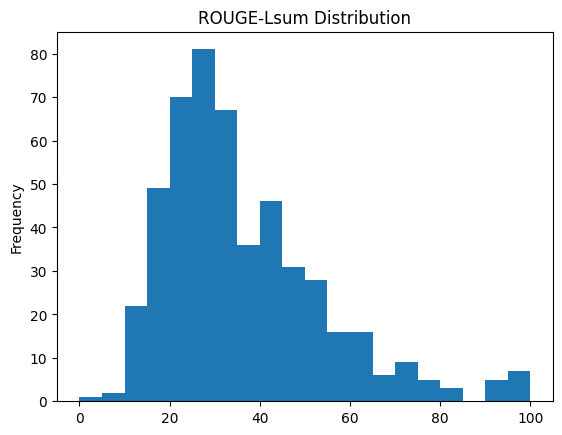

In [ ]:
overall_rouge, bart_eval_df = compute_rouge_and_store(model, tokenizer, tramainder_df)

# Top 10 weakest summaries
bart_eval_df.sort_values("rouge_lsum").head(10)

# Plot distribution
bart_eval_df["rouge_lsum"].plot(kind="hist", bins=20, title="ROUGE-Lsum Distribution")

In [26]:
# Show the 10 lowest ROUGE-Lsum scoring summaries with their reference summaries and index
lowest_10 = bart_eval_df.nsmallest(5, "rouge_lsum")[["dialogue", "bart_summary", "reference_summary"]]
lowest_10["index"] = lowest_10.index  # preserve original index for traceability

# Reorder columns for clarity
lowest_10 = lowest_10[["index", "bart_summary", "reference_summary"]]

# Display results
for i, row in lowest_10.iterrows():
    print(f"\n=== Sample {i+1} (Index {row['index']}) ===")
    print(f"BART Summary:      {row['bart_summary']}")
    print(f"Reference Summary: {row['reference_summary']}")



=== Sample 176 (Index 175) ===
BART Summary:      Jensen got this. Maria got it.
Reference Summary: Ioanna starts a new work today.

=== Sample 125 (Index 124) ===
BART Summary:      Finch and Paige are disgusted by the disgusting nature of the snail.
Reference Summary: Wilfred's got Randall's video. Paige and Finch find it disguising. Randall reckons it's fake. 

=== Sample 16 (Index 15) ===
BART Summary:      Laura is fed up with everything. Jenny will go home and get some sleep.
Reference Summary: Jenny's has fallen out with Claude. She's feeling blue.

=== Sample 237 (Index 236) ===
BART Summary:      Ruth picked up Janet from work. She took a taxi.
Reference Summary: Ruth got back with matthew because he was in town.

=== Sample 350 (Index 349) ===
BART Summary:      Peter doesn't have internet in his apartment.
Reference Summary: David and Tom's internet works well, so Peter will come over.


Keep in mind that we're looking at the 5 worst summaries out of 500 (by ROUGEL-sum). Still, this is bad. Let's look at dialogs for the first and last to see how they got there.

In [ ]:
sample_indices = [175, 349]

for idx in sample_indices:
    print(f"\n=== Sample {idx} ===\n")
    print(tramainder_df.loc[idx, "dialogue"])


=== Sample 175 ===

Ioanna: First day at work today!
Jensen: Good luck
Jensen: U got this
Maria: U got this!! 
Ioanna: <3

=== Sample 349 ===

Peter: Do you have internet in your apartment?
Tom: sure
David: of course, why?
Peter: mine doesn't work, may I come over?
David: sure!


#### Dialog Length

One thing to note is that both of these conversations are "too short to summarize".

Hypothesis: shorter conversations are associated with lower ROUGE scores (it is harder to match the target summary).

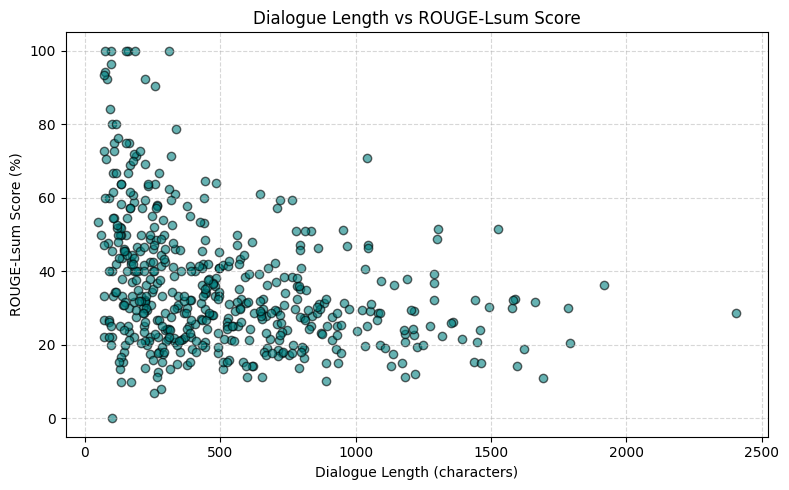

In [28]:
import matplotlib.pyplot as plt

# Compute dialogue lengths in characters
bart_eval_df["dialogue_length_chars"] = bart_eval_df["dialogue"].apply(len)

# Scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(
    bart_eval_df["dialogue_length_chars"],
    bart_eval_df["rouge_lsum"],
    alpha=0.6,
    color="teal",
    edgecolors="k"
)

plt.title("Dialogue Length vs ROUGE-Lsum Score")
plt.xlabel("Dialogue Length (characters)")
plt.ylabel("ROUGE-Lsum Score (%)")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [29]:
bart_eval_df[["dialogue_length_chars", "rouge_lsum"]].corr(method="pearson")


,dialogue_length_chars,rouge_lsum
dialogue_length_chars,1.000000,-0.333551
rouge_lsum,-0.333551,1.000000


Our dialog length hypothesis is a bust, and in fact the opposite is true. This probably makes intuitive sense; longer dialogs are harder to summarize.

### Speaker Count

Hypothesis: our BART model struggles to summarize conversations with lots of distinct speakers.

In [30]:
import re

def count_unique_speakers(dialogue):
    # re.M = multiline, re.I = case ignore
    speakers = re.findall(r"^([a-zA-Z]+):", dialogue, re.M | re.I)
    unique_speakers = set(name.strip().lower() for name in speakers)
    return len(unique_speakers)

# Apply the function to create a new column
bart_eval_df["speaker_count"] = bart_eval_df["dialogue"].apply(count_unique_speakers)


In [31]:
bart_eval_df[["speaker_count", "rouge_lsum"]].corr(method="pearson")

,speaker_count,rouge_lsum
speaker_count,1.000000,-0.029351
rouge_lsum,-0.029351,1.000000


With a weak correlation of ~3%, our hypothesis falls flat; the number of speakers is not very predictive of the ROUGE-Lsum.

## Conclusion

We have created a pipeline for using a pre-trained BART model to create dialog summaries. Due to computation restrictions, this model was trained on a very small subset of the data. However, the fact that it improved substantially between 100 and 500 samples indicates that if we scaled it up, it would likely improve further.